#  Прогнозирование заказов такси

**Описание компании:** Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель:** Построить модель для предсказания количества заказов такси на следующий час

**Задачи:** Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Примечание к проекту:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# Описание данных

Данные лежат в файле `taxi.csv`.

Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импортируем нужные библиотеки

In [1]:
# Импортируем нужные библиотеки

from matplotlib import pyplot
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from lightgbm import LGBMRegressor
from scipy.stats import poisson
from math import sqrt
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.stattools import adfuller
from catboost import CatBoostRegressor, Pool, cv
from statsmodels.graphics.tsaplots import plot_acf

import warnings
import xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
warnings.filterwarnings('ignore')

### Через блок try-except прочтем наш датасет и также сразу обработаем даты в качестве индекса

In [2]:
# Через блок try-except прочтем наш датасет
try:
    df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
except FileNotFoundError:
    print("FileNotFoundError: Проверьте корректность пути к файлу или наличие самого файла в каталоге!")

### Проведем сортировку индекса

In [3]:
# Проведем сортировку индекса
df.sort_index(inplace=True)

### Проведем ресемплинг данных по одному часу

In [4]:
# Проведем ресемплинг данных по одному часу
df = df.resample('1H').sum()

### Проверим, в хронологическом ли порядке расположены даты и время

In [5]:
# Проверим, в хронологическом ли порядке расположены даты и время
print(df.index.is_monotonic)

True


## Анализ

### Выведем первые 5 строк датасета

In [6]:
# зададим масштаб 
pd.set_option('display.max_columns', len(df.columns))
# выведем первые 5 строк датасета
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Просмотрим информацию об датасете

In [7]:
# Просмотрим информацию об датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Проверим количество нулевых значений

In [8]:
# Проверим количество нулевых значений
df.isna().sum()

num_orders    0
dtype: int64

### Визуализируем наш датасет

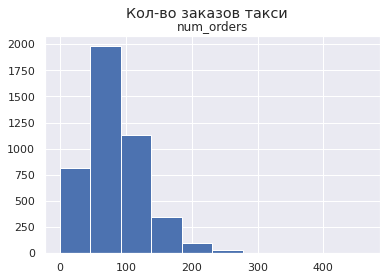

In [9]:
# Визуализируем наш датасе
df.hist();
plt.suptitle("Кол-во заказов такси");

### Посмотрим на количественные значения в датасете

In [10]:
# Посмотрим на количественные значения в датасете
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Визуализируем наш признак кол-во заказов чтобы увидеть потенциальные бОльшие значения (аномалии)

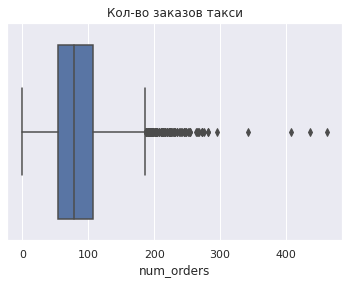

In [11]:
plt.title('Кол-во заказов такси')
sns.boxplot(df['num_orders']);

### Создадим копию нашего датасета и посмотрим на 'rolling_mean' и 'std'

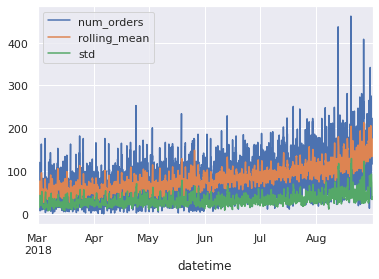

In [12]:
df_dub = df.copy()

df_dub['rolling_mean'] = df_dub.rolling(10).mean()
df_dub['std'] = df_dub['num_orders'].rolling(10).std()

df_dub.plot();

### Сделаем декомпозицию на тренд и сезонность, чтобы понять найденную сезонность

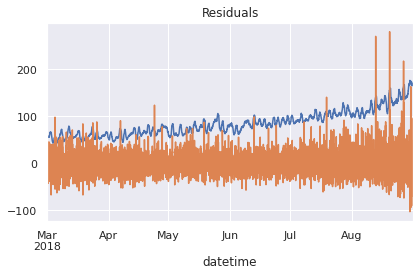

In [13]:
decomposed = seasonal_decompose(df)

plt.title('Trend')
decomposed.trend.plot(ax=plt.gca())

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

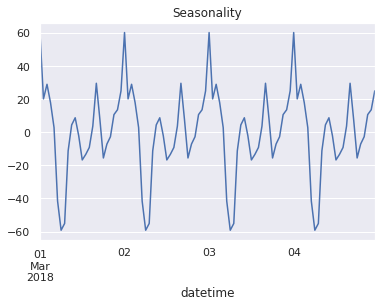

In [14]:
plt.title('Seasonality')
decomposed.seasonal['2018-03-01': '2018-03-04'].plot(ax=plt.gca());

### Проверим, есть ли кроме суточной еще и недельная сезонность

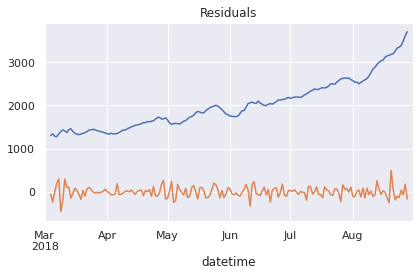

In [15]:
df1 = df.copy()

df1 = df1.resample('1D').sum()

decomposed = seasonal_decompose(df1)

plt.title('Trend')
decomposed.trend.plot(ax=plt.gca());

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

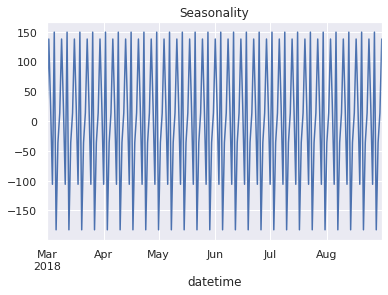

In [16]:
plt.title('Seasonality')
decomposed.seasonal.plot(ax=plt.gca());

**Для более точной оценки стационарности применим тест Дики-Фуллера**

**Гипотезы звучат следующим образом:**

     (H0) Нулевая гипотеза предполагает, что процесс нестационарный
     (H1) Альтернативная гипотеза соответственно говорит об обратном

In [17]:
# импортируем необходимую функцию 
# from statsmodels.tsa.stattools import adfuller
 
# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(df['num_orders'])
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.028940051402612906


**Посмотрим на Автокорреляцию**

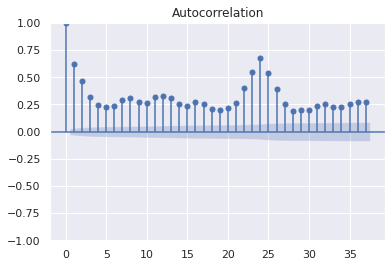

In [18]:
# применим ее к данным о пассажирах
plot_acf(df)
plt.show()

### Выводы по подготовке данных

1. Было обнаружено, что в данных нет пропусков
2. Наибольшее число значений количества заказов, лежит в промежутке 13 - 19
3. Данный временной ряд не стационарен, так как колебания значений, а именно число заказов - зависит от времени
4. Мы с помощью seasonal_decompose выявили дневную и недельную сезоность. 

## Обучение

### Создадим функцию для создания признаков

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

### Передадим в фунцию наш датасет, максимальную задержку а также размер для скользящих

In [20]:
# make_features(df, 5, 6)

In [21]:
make_features(df, 500, 24)

### Разделим наши выборки, чтобы тестовый у нас составлял не более 10%

In [22]:
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=42)

### Выведем нашу тренировочную выборку

In [23]:
pd.set_option('display.max_columns', len(df.columns))
train.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_170,lag_171,lag_172,lag_173,lag_174,lag_175,lag_176,lag_177,lag_178,lag_179,lag_180,lag_181,lag_182,lag_183,lag_184,lag_185,lag_186,lag_187,lag_188,lag_189,lag_190,lag_191,lag_192,lag_193,lag_194,lag_195,lag_196,lag_197,lag_198,lag_199,lag_200,lag_201,lag_202,lag_203,lag_204,lag_205,lag_206,lag_207,lag_208,lag_209,lag_210,lag_211,lag_212,lag_213,lag_214,lag_215,lag_216,lag_217,lag_218,lag_219,lag_220,lag_221,lag_222,lag_223,lag_224,lag_225,lag_226,lag_227,lag_228,lag_229,lag_230,lag_231,lag_232,lag_233,lag_234,lag_235,lag_236,lag_237,lag_238,lag_239,lag_240,lag_241,lag_242,lag_243,lag_244,lag_245,lag_246,lag_247,lag_248,lag_249,lag_250,lag_251,lag_252,lag_253,lag_254,lag_255,lag_256,lag_257,lag_258,lag_259,lag_260,lag_261,lag_262,lag_263,lag_264,lag_265,lag_266,lag_267,lag_268,lag_269,lag_270,lag_271,lag_272,lag_273,lag_274,lag_275,lag_276,lag_277,lag_278,lag_279,lag_280,lag_281,lag_282,lag_283,lag_284,lag_285,lag_286,lag_287,lag_288,lag_289,lag_290,lag_291,lag_292,lag_293,lag_294,lag_295,lag_296,lag_297,lag_298,lag_299,lag_300,lag_301,lag_302,lag_303,lag_304,lag_305,lag_306,lag_307,lag_308,lag_309,lag_310,lag_311,lag_312,lag_313,lag_314,lag_315,lag_316,lag_317,lag_318,lag_319,lag_320,lag_321,lag_322,lag_323,lag_324,lag_325,lag_326,lag_327,lag_328,lag_329,lag_330,lag_331,lag_332,lag_333,lag_334,lag_335,lag_336,lag_337,lag_338,lag_339,lag_340,lag_341,lag_342,lag_343,lag_344,lag_345,lag_346,lag_347,lag_348,lag_349,lag_350,lag_351,lag_352,lag_353,lag_354,lag_355,lag_356,lag_357,lag_358,lag_359,lag_360,lag_361,lag_362,lag_363,lag_364,lag_365,lag_366,lag_367,lag_368,lag_369,lag_370,lag_371,lag_372,lag_373,lag_374,lag_375,lag_376,lag_377,lag_378,lag_379,lag_380,lag_381,lag_382,lag_383,lag_384,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392,lag_393,lag_394,lag_395,lag_396,lag_397,lag_398,lag_399,lag_400,lag_401,lag_402,lag_403,lag_404,lag_405,lag_406,lag_407,lag_408,lag_409,lag_410,lag_411,lag_412,lag_413,lag_414,lag_415,lag_416,lag_417,lag_418,lag_419,lag_420,lag_421,lag_422,lag_423,lag_424,lag_425,lag_426,lag_427,lag_428,lag_429,lag_430,lag_431,lag_432,lag_433,lag_434,lag_435,lag_436,lag_437,lag_438,lag_439,lag_440,lag_441,lag_442,lag_443,lag_444,lag_445,lag_446,lag_447,lag_448,lag_449,lag_450,lag_451,lag_452,lag_453,lag_454,lag_455,lag_456,lag_457,lag_458,lag_459,lag_460,lag_461,lag_462,lag_463,lag_464,lag_465,lag_466,lag_467,lag_468,lag_469,lag_470,lag_471,lag_472,lag_473,lag_474,lag_475,lag_476,lag_477,lag_478,lag_479,lag_480,lag_481,lag_482,lag_483,lag_484,lag_485,lag_486,lag_487,lag_488,lag_489,lag_490,lag_491,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

### Проверим корректность разделенных выборок а также удалим пропуски из тренировочной выборки

In [24]:
train = train.dropna()
print(train.shape)
print(test.shape)
# print()
# print()

(3474, 504)
(442, 504)


### Выведем максимальные и минимальные индексы наших обучающего и тренировочного выборок

In [25]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-21 20:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


### Выделим признаки и целевой признак для тренировочной и тестовой выборки

In [26]:
# X - features
X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)

# y - target
y_test = test['num_orders']
y_train = train['num_orders']

### Произведем One-Hot-Encoder кодирование выборок отдельно для Линейной регресии, так как модель с таким кодированием работает лучше

In [27]:
cat = list(X_train.select_dtypes('object').columns)
num = list(X_train.select_dtypes(exclude='object').columns)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[num]), columns=[num], index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[num]), columns=[num], index=X_test.index)

enc = OneHotEncoder(handle_unknown='ignore')

X_train_ohe = enc.fit_transform(X_train[cat])
X_test_ohe = enc.transform(X_test[cat])

X_train_lr = pd.concat([X_train_scaled, pd.DataFrame(X_train_ohe.toarray(), index=X_train.index)], axis=1)
X_test_lr  = pd.concat([X_test_scaled, pd.DataFrame(X_test_ohe.toarray(), index=X_test.index)], axis=1)

### Произведем визуальное представление об наших выборках

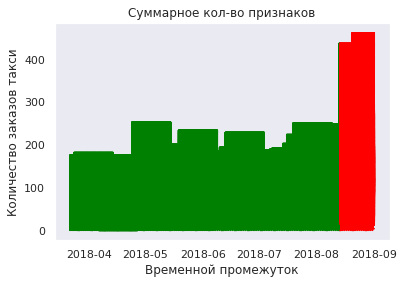

In [28]:
plt.plot(X_train, color = "green")
plt.plot(X_test, color = "red")
 
# заголовок и подписи к осям
plt.title('Суммарное кол-во признаков')
plt.ylabel('Количество заказов такси')
plt.xlabel('Временной промежуток')
 
# добавим сетку
plt.grid()
plt.show()

### Введем и будем использовать TimeSeriesSplit

In [29]:
tscv = TimeSeriesSplit(n_splits=5)

# LinearRegression

In [30]:
lin_regr = LinearRegression()

tscv = TimeSeriesSplit(n_splits=5)

lin = cross_val_score(lin_regr, X_train_lr, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

print(f"RMSE модели {lin_regr}:", lin.mean() * (-1))

RMSE модели LinearRegression(): 38.338137088412154


# DecisionTreeRegressor

**Произведем подбор гиперпараметров через оптимизатор**

In [31]:
%%time  

model_decision = DecisionTreeRegressor(random_state=42)

parametrs  = {'max_depth' : [2, 3, 4, 5, 6],
             'min_samples_leaf' : [1, 2, 3, 4, 5]
}
    
grid = GridSearchCV(estimator=model_decision, param_grid = parametrs, cv=tscv, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)
print(f"Получили лучшие гиперпараметры: {grid.best_params_} - их и будем использовать как лучшие") 
print(-grid.best_score_)

Получили лучшие гиперпараметры: {'max_depth': 5, 'min_samples_leaf': 2} - их и будем использовать как лучшие
26.578747203029252
CPU times: user 23.5 s, sys: 317 ms, total: 23.8 s
Wall time: 23.8 s


# LGBMRegressor

**Произведем подбор гиперпараметров через оптимизатор GridSearchCV**

In [32]:
%%time
param_grid = {'max_depth':[2, 4, 6, 8],
              'n_estimators' : [100, 200, 300, 400],
              'learning_rate': [0.05, 0.1]
}

lgb_estimator = LGBMRegressor(random_state=42) 
                                

lgbm_grid = GridSearchCV(estimator = lgb_estimator,\
                               param_grid = param_grid,\
                               n_jobs=1,\
                               verbose=10,\
                               scoring= 'neg_root_mean_squared_error',\
                               cv=tscv)

lgbm_grid.fit(X_train, y_train)
print('best params', lgbm_grid.best_params_)
print('best score', lgbm_grid.best_score_)


# best params {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}
# best score -22.612644322113177
# CPU times: user 24min 9s, sys: 5.79 s, total: 24min 14s
# Wall time: 24min 42s

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START learning_rate=0.05, max_depth=2, n_estimators=100..........
[CV 1/5; 1/32] END learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.7s
[CV 2/5; 1/32] START learning_rate=0.05, max_depth=2, n_estimators=100..........
[CV 2/5; 1/32] END learning_rate=0.05, max_depth=2, n_estimators=100; total time=   1.1s
[CV 3/5; 1/32] START learning_rate=0.05, max_depth=2, n_estimators=100..........
[CV 3/5; 1/32] END learning_rate=0.05, max_depth=2, n_estimators=100; total time=   1.3s
[CV 4/5; 1/32] START learning_rate=0.05, max_depth=2, n_estimators=100..........
[CV 4/5; 1/32] END learning_rate=0.05, max_depth=2, n_estimators=100; total time=   1.7s
[CV 5/5; 1/32] START learning_rate=0.05, max_depth=2, n_estimators=100..........
[CV 5/5; 1/32] END learning_rate=0.05, max_depth=2, n_estimators=100; total time=   1.8s
[CV 1/5; 2/32] START learning_rate=0.05, max_depth=2, n_estimators=200..........
[CV 1/5

# CatBoostRegressor

**Произведем подбор гиперпараметров через оптимизатор GridSearchCV**

In [33]:
%%time
param_grid = {'max_depth':[2, 3, 4, 5, 6, 7, 8, 9],
              'n_estimators' : [100, 200, 300, 400]
}

catboost_estimator = CatBoostRegressor(random_state=42) 
                                

catboost_grid = GridSearchCV(estimator = catboost_estimator,\
                               param_grid = param_grid,\
                               n_jobs=1,\
                               verbose=10,\
                               scoring= 'neg_root_mean_squared_error',\
                               cv=tscv)

catboost_grid.fit(X_train, y_train)

print('best params', catboost_grid.best_params_)
print('best score', catboost_grid.best_score_)

# best params {'max_depth': 2, 'n_estimators': 400}
# best score -22.778546851945187
# CPU times: user 1h 38min 19s, sys: 37.2 s, total: 1h 38min 56s
# Wall time: 1h 41min 34s

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START max_depth=2, n_estimators=100..............................
Learning rate set to 0.244165
0:	learn: 27.4946204	total: 58.6ms	remaining: 5.8s
1:	learn: 25.4371628	total: 68.7ms	remaining: 3.36s
2:	learn: 24.2060314	total: 77.7ms	remaining: 2.51s
3:	learn: 22.7426526	total: 86.6ms	remaining: 2.08s
4:	learn: 21.9125622	total: 96.1ms	remaining: 1.82s
5:	learn: 21.1446464	total: 105ms	remaining: 1.65s
6:	learn: 20.3824692	total: 116ms	remaining: 1.53s
7:	learn: 19.6841190	total: 125ms	remaining: 1.44s
8:	learn: 19.0494046	total: 136ms	remaining: 1.37s
9:	learn: 18.5517659	total: 145ms	remaining: 1.31s
10:	learn: 18.1980566	total: 154ms	remaining: 1.25s
11:	learn: 17.8790412	total: 164ms	remaining: 1.21s
12:	learn: 17.6719350	total: 174ms	remaining: 1.16s
13:	learn: 17.4575216	total: 183ms	remaining: 1.12s
14:	learn: 17.2958266	total: 192ms	remaining: 1.09s
15:	learn: 17.1365910	total: 201ms	remaining: 1.06s
1

### Введем baseline модель

In [34]:
def rmse(a, b):
    return mean_squared_error(a, b) ** 0.5

In [35]:
customer_score = make_scorer(rmse, greater_is_better = False)

In [36]:
baseline = DummyRegressor(strategy='mean').fit(X_train, y_train)
baseline_predicted = baseline.predict(X_test)
baseline_rmse = rmse(y_test, baseline_predicted)
print("RMSE Baseline:", baseline_rmse)

RMSE Baseline: 82.45537237656461


### Выводы по обучению

1. Создали функцию для создания признаков в датасете;
2. Разделили наши выборки, - проверили корретность разделения;
3. Выбрали в качестве моделей LinearRegression, DecisionTreeRegressor, LGBMRegressor и CatBoostRegressor;
4. Наилучшая модель, которая показала себя на тренировочной выборке - CatBoostRegressor;
5. RMSE наилучшей модели = 26.64834953745922

****

## Тестирование

In [38]:
# LGBMRegressor

rmse_test = mean_squared_error(y_test, lgbm_grid.best_estimator_.predict(X_test)) ** 0.5
print(f"RMSE:", rmse_test)

RMSE: 37.06747419996629


### Выводы по тестированию

1. Проверили CatBoostRegressor на тренировочной модели
2. Была произведена проверка адекватности модели
3. RMSE лучшей модели на тестовой выборке = 47.23433652701181

## Конечные выводы



**Выводы по подготовке данных**
   
    1. Было обнаружено, что в данных нет пропусков
    2. Наибольшее число значений количества заказов, лежит в промежутке 13 - 19
    3. Данный временной ряд не стационарен, так как колебания значений, а именно число заказов - зависит от времени
    4. Мы с помощью seasonal_decompose выявили дневную и недельную сезоность. 

**Выводы по обучению**

    1. Создали функцию для создания признаков в датасете;
    2. Разделили наши выборки, - проверили корретность разделения;
    3. Выбрали в качестве моделей LinearRegression, DecisionTreeRegressor, LGBMRegressor и CatBoostRegressor;
    4. Наилучшая модель, которая показала себя на тренировочной выборке - CatBoostRegressor;
    5. RMSE наилучшей модели = 26.64834953745922
    
**Выводы по тестированию**

      1. Проверили модель на тренировочной выборке
      2. Была произведена проверка адекватности моделей
      4. RMSE лучшей модели = 47.23433652701181